<a href="https://colab.research.google.com/github/vjihye/TIL/blob/master/3_10__Convnet_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing heat maps of class activation

In [23]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [24]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [25]:
img_path = './creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

### 이미지에 대한 상위3개 예측 

In [26]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted: [('n02504458', 'African_elephant', 0.89544886), ('n01871265', 'tusker', 0.09967599), ('n02504013', 'Indian_elephant', 0.004639555)]


In [27]:
np.argmax(preds[0])

386

### • Grad-CAM 알고리즘 설정

In [30]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [32]:
from keras import backend as K

In [33]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [35]:
import matplotlib.pyplot as plt

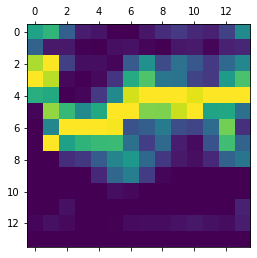

In [36]:
heatmap = np.maximum(heatmap,0)
heatmap/=np.max(heatmap,0)
plt.matshow(heatmap)

### 원본 이미지에 heatmap 덧붙이기

In [38]:
import cv2

In [39]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap*0.4+img

cv2.imwrite('./elephant_cam.jpg', superimposed_img)

True

In [40]:
superimposed_img

array([[[253.6, 317. , 276.8],
        [252.6, 316. , 275.8],
        [251.6, 315. , 274.8],
        ...,
        [279. , 302. , 229.4],
        [279. , 302. , 229.4],
        [279. , 302. , 229.4]],

       [[253.6, 317. , 276.8],
        [252.6, 316. , 275.8],
        [252.6, 316. , 275.8],
        ...,
        [279. , 302. , 229.4],
        [279. , 302. , 229.4],
        [279. , 302. , 229.4]],

       [[253.6, 317. , 276.8],
        [252.6, 316. , 275.8],
        [252.6, 316. , 275.8],
        ...,
        [280. , 303. , 230.4],
        [279. , 302. , 229.4],
        [279. , 302. , 229.4]],

       ...,

       [[134.2, 135. , 125. ],
        [104.2, 106. ,  96. ],
        [115.2, 123. , 109. ],
        ...,
        [ 94.2,  85. ,  78. ],
        [112.2, 101. ,  96. ],
        [133.2, 122. , 117. ]],

       [[129.2, 130. , 120. ],
        [101.2, 103. ,  93. ],
        [118.2, 126. , 112. ],
        ...,
        [112.2, 103. ,  96. ],
        [133.2, 122. , 117. ],
        [123.2,

In [41]:
cv_img = './elephant_cam.jpg'

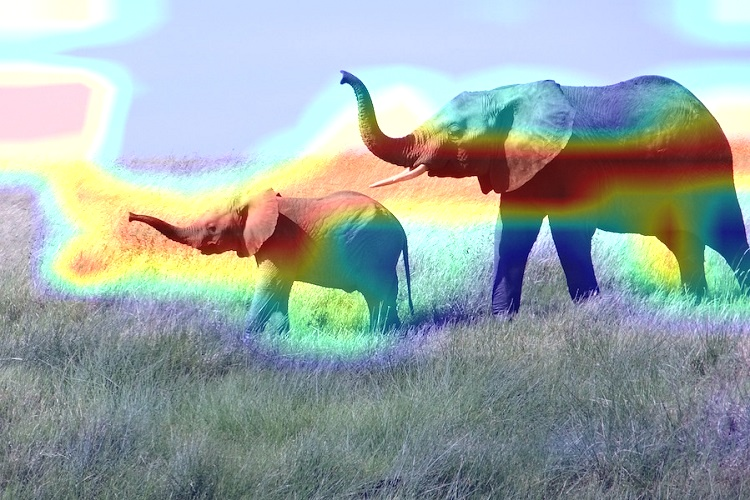

In [43]:
from IPython.display import Image, display
display(Image(cv_img))